In [1]:
from scipy.io.matlab import loadmat 
import numpy as np
import matplotlib.pyplot as plt

import torch as torch
import torch.nn as nn
cuda = torch.device("cuda:0")

### Helper functions

In [2]:
def count_parameters(model):
    '''
    Count total number of parameters in model
    '''
    n_param = 0
    for parameter in model.parameters():
        numpy = parameter.detach().numpy()
        n_param += np.product(numpy.shape)
    return n_param

In [3]:
def conv_output_width(input_width,kernel_width,stride,repeat = 1):
    '''
    calculate output-width of (stacked) conv-layers
    '''
    out_width = input_width
    for _ in range(repeat):
        out_width = int((out_width - kernel_width - 0)/stride + 1)
    return out_width

# Data import

In [4]:
input_100pM_p1 = loadmat('Data/Stimulation_100pM_2013.mat')
input_100pM_p2 = loadmat('Data/Stimulation_100pM_2014.mat')
combined_data = np.concatenate((input_100pM_p1['DataOI_r'].T,input_100pM_p2['DataOI_r'].T))
print(combined_data.shape)

(730, 289)


# GAN Models

In [219]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        drop_rate = 0.3
        
        self.classify = nn.Sequential(
            nn.Linear(289,2*289),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            
            nn.Linear(2*289,256),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            
            nn.Linear(256,64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            
            nn.Linear(64,16),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            
            nn.Linear(16,1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = torch.reshape(x,[-1,289])
        x = self.classify(x)
        return x

In [422]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.generate = nn.Sequential(
            nn.Linear(16,64,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            
            nn.Linear(64,128,bias=False),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(128),
            
            nn.Linear(128,256,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            
            nn.Linear(256,289,bias=False),
            #nn.BatchNorm1d(289),
            nn.ReLU(inplace=True),
            
        )
    
        self.conv = nn.Sequential(
            nn.Conv1d(1,1,5,padding='same',bias=False),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv1d(1,1,7,padding='same',bias=True),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv1d(1,1,11,padding='same',bias=False),
            nn.LeakyReLU(0.1,inplace=True)
        )
    
    def forward(self,x):
        x = self.generate(x)
        x = torch.reshape(x,[-1,1,289])
        x = self.conv(x)
        return x #torch.reshape(x,[-1,1,289])

In [423]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.5)
        print('rescaled',classname)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.5)
        nn.init.constant_(m.bias.data, 0)

In [424]:
torch.manual_seed(32)
gen = Generator().to(cuda)
gen.apply(weights_init)
dis = Discriminator().to(cuda)

rescaled Linear
rescaled Linear
rescaled Linear
rescaled Linear
rescaled Conv1d
rescaled Conv1d
rescaled Conv1d


### Prove of concept: Does the scale of the noise match?

torch.Size([3, 1, 289])


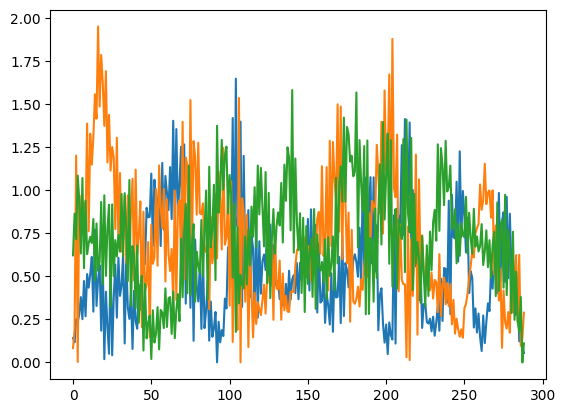

In [425]:
n_samp = 3
gen_noise = torch.randn(n_samp,16).to(cuda)
fakes = gen(gen_noise)
print(fakes.shape)
data = fakes.detach().cpu().numpy().reshape([n_samp,-1]).T
plt.plot(data)
plt.show()

# GAN Training

In [426]:
epochs = 2000
noise_len = 16
max_patients = 5
batch_size = 128
learning_reate_gen = 3e-4
learning_rate_dis = 3e-4
beta1 = 0.5
beta2 = 0.999
L2_lambda = 0.003

real_label = 1
fake_label = 0

dataloader = torch.utils.data.DataLoader(combined_data.reshape([-1,1,289]), batch_size=batch_size)
n_data = combined_data.shape[0]
torch.manual_seed(33)

const_noise = torch.randn(batch_size,noise_len).to(cuda)

criterion = nn.BCELoss()
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=learning_rate_dis, betas=(beta1, beta2))
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_reate_gen, betas=(beta1, beta2))

scores_dis_real = []
scores_dis_fake = []
scores_gen_fake = []

losses_dis_real = []
losses_dis_fake = []
losses_gen_fake = []

inter_images = []
patients = 0
for e in range(epochs):

    running_scores_dis_real = 0.0
    running_scores_dis_fake = 0.0
    running_scores_gen_fake = 0.0
    
    running_loss_dis_real = 0.0
    running_loss_dis_fake = 0.0
    running_loss_gen_fake = 0.0

    for samp in dataloader:
        real_labels = torch.full((samp.shape[0],1), real_label, dtype=torch.float).to(cuda)
        fake_labels = torch.full((samp.shape[0],1), fake_label, dtype=torch.float).to(cuda)

        
        # Train discriminator
        dis.train()
        # ~ on real data
        real_scores = dis.forward(samp.float().to(cuda))
        err_diss_real = criterion(real_scores, real_labels) + L2_lambda * sum(p.pow(2.0).sum() for p in dis.parameters())
        if e==0 or scores_dis_real[-1] < 0.6:
            dis.zero_grad()
            err_diss_real.backward()

        running_scores_dis_real += real_scores.sum().item()
        running_loss_dis_real += err_diss_real.sum().item()
        
        # ~ on fake data
        gen.eval()
        gen_noise = torch.randn(samp.shape[0], noise_len).to(cuda)
        fakes = gen(gen_noise)
        fake_scores = dis(fakes.detach())
        err_diss_fake = criterion(fake_scores, fake_labels)
        err_diss_fake.backward()
        running_scores_dis_fake += fake_scores.sum().item()
        running_loss_dis_fake += err_diss_fake.sum().item()
        optimizer_dis.step()
        
        # Train generator
        gen.train()
        gen.zero_grad()
        fake_dis_scores = dis(fakes)
        err_gen_fake = criterion(fake_dis_scores, real_labels)
        err_gen_fake.backward()
        running_scores_gen_fake += fake_dis_scores.sum().item()
        running_loss_gen_fake += err_gen_fake.sum().item()
        optimizer_gen.step()

    scores_dis_real.append(running_scores_dis_real/n_data)
    scores_dis_fake.append(running_scores_dis_fake/n_data)
    scores_gen_fake.append(running_scores_gen_fake/n_data)
    losses_dis_real.append(running_loss_dis_real/n_data)
    losses_dis_fake.append(running_loss_dis_fake/n_data)
    losses_gen_fake.append(running_loss_gen_fake/n_data)
    
    if (e+1)%100 == 0:
        validate_fakes = gen(const_noise)
        inter_images.append(validate_fakes)   
        
    if (e+1)%50 == 0:      
        print(f'Epoch {e+1:3d}: Scores: Dis real:{scores_dis_real[-1]*100:.1f}%,  Dis fake:{scores_dis_fake[-1]*100:.1f}%,  Gen fake:{scores_gen_fake[-1]*100:.1f}%')
        print(f'           Losses: Dis real:{losses_dis_real[-1]:.3f},  Dis fake:{losses_dis_fake[-1]:.3f},  Gen fake:{losses_gen_fake[-1]:.3f}')
   
    if np.abs(scores_dis_real[-1] - 0.5) < 0.001:
        patients += 1
        if patients == max_patients:
            print('Converged at 50%')
            break
    elif patients > 0:
        patients -= 1

Epoch  50: Scores: Dis real:53.6%,  Dis fake:53.0%,  Gen fake:52.0%
           Losses: Dis real:0.010,  Dis fake:0.006,  Gen fake:0.005
Epoch 100: Scores: Dis real:49.3%,  Dis fake:47.7%,  Gen fake:47.8%
           Losses: Dis real:0.010,  Dis fake:0.005,  Gen fake:0.006
Epoch 150: Scores: Dis real:55.6%,  Dis fake:49.7%,  Gen fake:49.5%
           Losses: Dis real:0.009,  Dis fake:0.006,  Gen fake:0.006
Epoch 200: Scores: Dis real:55.8%,  Dis fake:43.9%,  Gen fake:43.4%
           Losses: Dis real:0.008,  Dis fake:0.005,  Gen fake:0.007
Epoch 250: Scores: Dis real:53.0%,  Dis fake:39.6%,  Gen fake:38.8%
           Losses: Dis real:0.008,  Dis fake:0.004,  Gen fake:0.009
Epoch 300: Scores: Dis real:54.3%,  Dis fake:42.3%,  Gen fake:40.1%
           Losses: Dis real:0.008,  Dis fake:0.005,  Gen fake:0.008
Epoch 350: Scores: Dis real:55.5%,  Dis fake:38.9%,  Gen fake:39.5%
           Losses: Dis real:0.007,  Dis fake:0.004,  Gen fake:0.008
Epoch 400: Scores: Dis real:52.2%,  Dis fake:50.

# Verify the training: Scores remains stable at ~50%

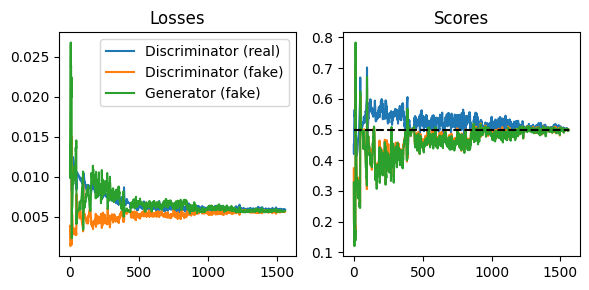

In [429]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(losses_dis_real,label='Discriminator (real)')
plt.plot(losses_dis_fake,label='Discriminator (fake)')
plt.plot(losses_gen_fake,label='Generator (fake)')
plt.legend()
plt.title('Losses')

plt.subplot(1,2,2)
plt.plot(scores_dis_real)
plt.plot(scores_dis_fake)
plt.plot(scores_gen_fake)
plt.plot([0,len(scores_dis_fake)],[0.5,0.5],'k--')
plt.title('Scores')
plt.tight_layout()

(289, 128)


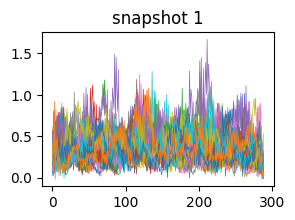

(289, 128)


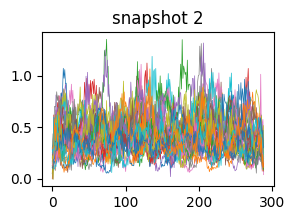

(289, 128)


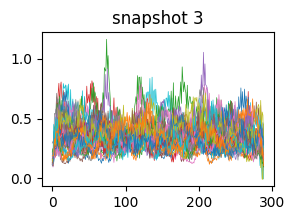

(289, 128)


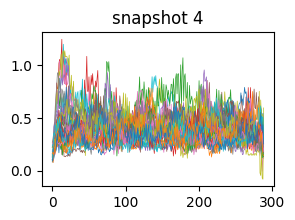

(289, 128)


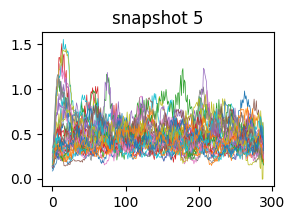

(289, 128)


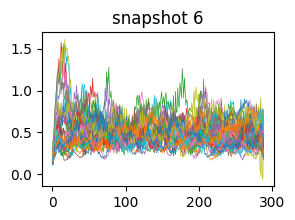

(289, 128)


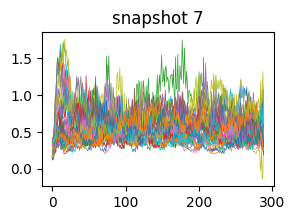

(289, 128)


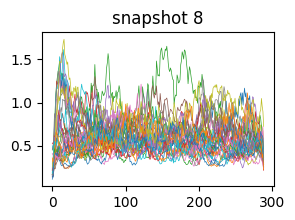

(289, 128)


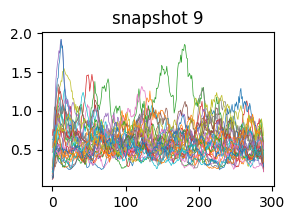

(289, 128)


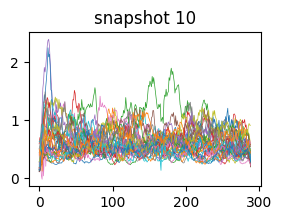

(289, 128)


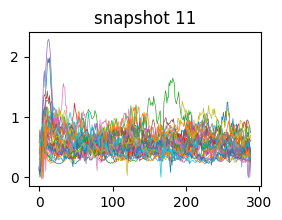

(289, 128)


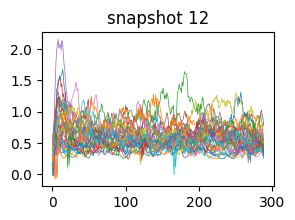

(289, 128)


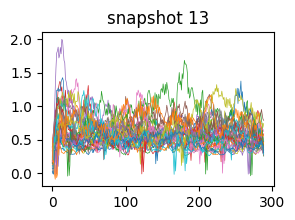

(289, 128)


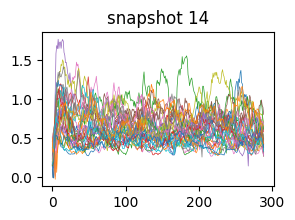

(289, 128)


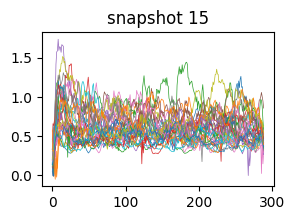

In [431]:
for k,snap_shot in enumerate(inter_images):
    data = snap_shot.detach().cpu().numpy().reshape([-1,289]).T
    plt.figure(figsize=(3,2))
    plt.plot(data[:,:32],linewidth=0.5)
    plt.title('snapshot %d'%(k+1))
    plt.show()

(289, 128)


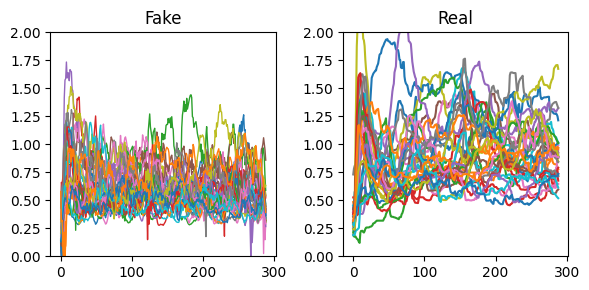

In [432]:
#torch.manual_seed(12)
#gen_noise = torch.randn(samp.shape[0], 2,13)
#fakes = gen(gen_noise)
data = inter_images[-1].detach().cpu().numpy().reshape([-1,289]).T
print(data.shape)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(data[:,:32],linewidth=1)
plt.ylim([0,2])
plt.title('Fake')

plt.subplot(1,2,2)
plt.plot(combined_data[:32].T)
plt.title('Real')
plt.ylim([0,2])

plt.tight_layout()